# **Data Harmonization**

Nowadays, people still tend to confuse *Data Science* with *Big Data*. Indeed, we have more data than ever before. However, there are still large industries where *Small Data* is extremely common. A clear example of this is the **Clinical Research**, where the rarity of a disease, the cost, and the disponibility of subjects make it extremely harder to get a decent dataset.

For this reason, **multi-site neuroimaging studies** are becoming more and more frequent among medical studies. Multi-site neuroimaging studies mean that the data which compose the dataset comes from different sources. An example of this is a dataset that is built from two different samples, which were collected in different places.

This allowed to conduct studies without having to worry about the problems of small datasets (Over-Fitting, Outliers, noise...). But all this come with a slight disadvantage, having data from different sources usually implies to handle with non-biological variance introduced by the application of different techniques or the use of different machines. 

Fortunately, some research has been done through this topic. The procediments involved in solving this type of issues are called **Harmonization Techniques**.

## *1. Load the Data*

In [205]:
from load_data import data_loader

full_dataset, fa, func, gm = data_loader(check_connectivity = True, unzip=False)


Checking Connectivity

Connection Test Complited: 
The following Controls didn't pass the test:  [['080MSVIS', ['ctx-rh-entorhinal', 'ctx-rh-transversetemporal']], ['119MSVIS', ['ctx-rh-entorhinal']], ['FIS_080', ['ctx-lh-entorhinal']], ['FIS_115', ['ctx-rh-entorhinal']]]


## *2. Basic information about the dataset*

For this project, our database is composed of **165** subjects, eighteen controls, and one hundred and forty-eight patients. The data is split into four different files: 3 files which include FA information, FUNC (functional) information, and GM_networks (Grey Matter) information (*Neuroimaging information*), and an xlsx file containing information such as the age and gender of the subjects as well as other useful data about the disease (*Clinical information*).

The subjects of this study comes from two different sources: *MSVIS* and *FIS*. In the following sections we'll determine if there is a problem related with "Scanner Effects" (multi-site neuroimaging problems) and, if necessary, we'll apply harmonization techniques.

## *3. Scanner Effects Detection*

One of the main studies in detection and harmonizing neuroimaging data belongs to Fortin et al. (2017), *Harmonization of cortical thickness measurements across scanners and sites*. In this project we'll apply the same detection techniques and solutions.

For *Scanner Effects* detection, they used dimensionality reduction techniques, such as *Principal Component Analysis* (PCA) and *Linear Discriminant Analysis* (LDA), to reduce the feature space to two dimensions. This allows to an easier visualization of the data.

### 3.1. PCA

*Principal Component Analysis* is, by far, the most used algorithm in terms of dimensionality reduction. Its popularity is due to its capacity to identify the hyperplane which stays closer to the data and then project the data in it.

One of the main characteristics of this algorithm is that preserves the variance. The first principal component takes the hyperplane which contains the maximum amount of variance, the second principal component takes the hyperplane which contains the second maximum amount of variance, and so on.

First of all, before applying PCA to our data, let's visualize the amount of variance taken by each principal component.

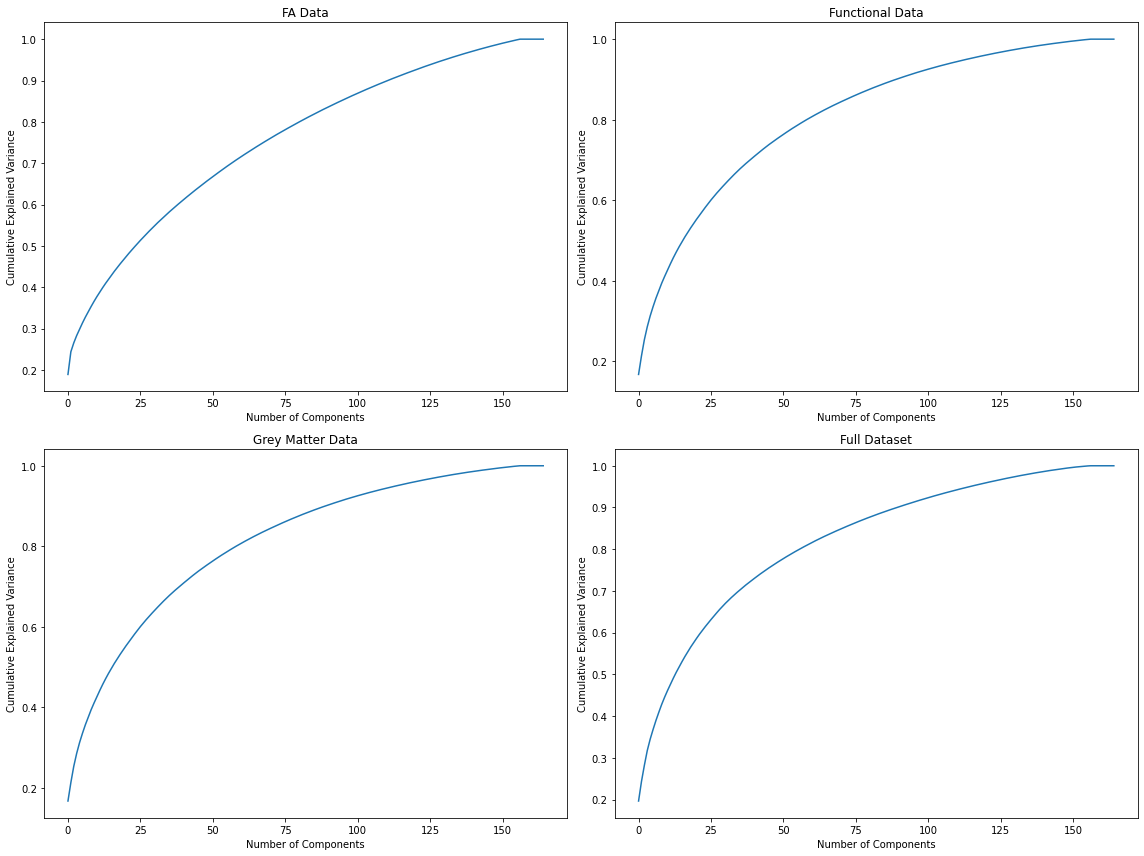

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

data = [fa.iloc[:, :-5], func.iloc[:, :-5], gm.iloc[:, :-5], full_dataset.iloc[:, :-5]]
names = ["FA Data", "Functional Data", "Grey Matter Data", "Full Dataset"]

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i in range(2):
    for j in range(2):
        pca_variables = data[i+j]
        pca = PCA().fit(pca_variables)
        axs[i, j].plot(np.cumsum(pca.explained_variance_ratio_))

for i,ax in enumerate(axs.flat):
    ax.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance', title=names[i])

fig.tight_layout()

### **Note:** Full Dataset has clinical data inside, we should clean that data before doing PCA or LDA.

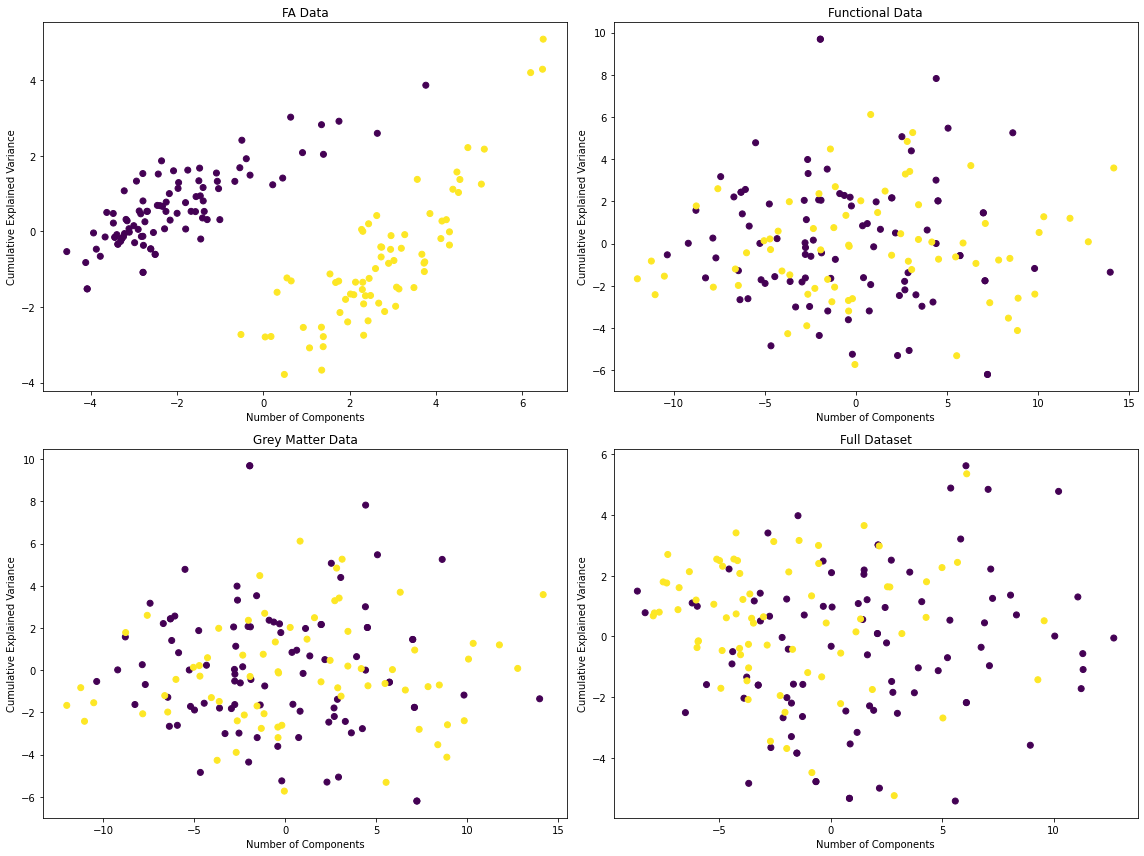

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i in range(2):
    for j in range(2):
        pca_variables = data[i+j]
        pca = PCA(n_components=2)
        pca_fa = pd.concat([pd.DataFrame(pca.fit_transform(pca_variables)), types], join="inner", axis=1)
        axs[i, j].scatter(x=pca_fa[0], y=pca_fa[1], c=pca_fa["type"])

for i,ax in enumerate(axs.flat):
    ax.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance', title=names[i])
    
fig.tight_layout()

### 3.2. Linear Discriminant Analysis

LDA consists of a classification algorithm that, during training, learns the more discriminatory axes between classes. After training these axes can be used to identify a hyperplane to project the data. The main advantage of this algorithm is that it will focus on maintaining the classes as far as possible.

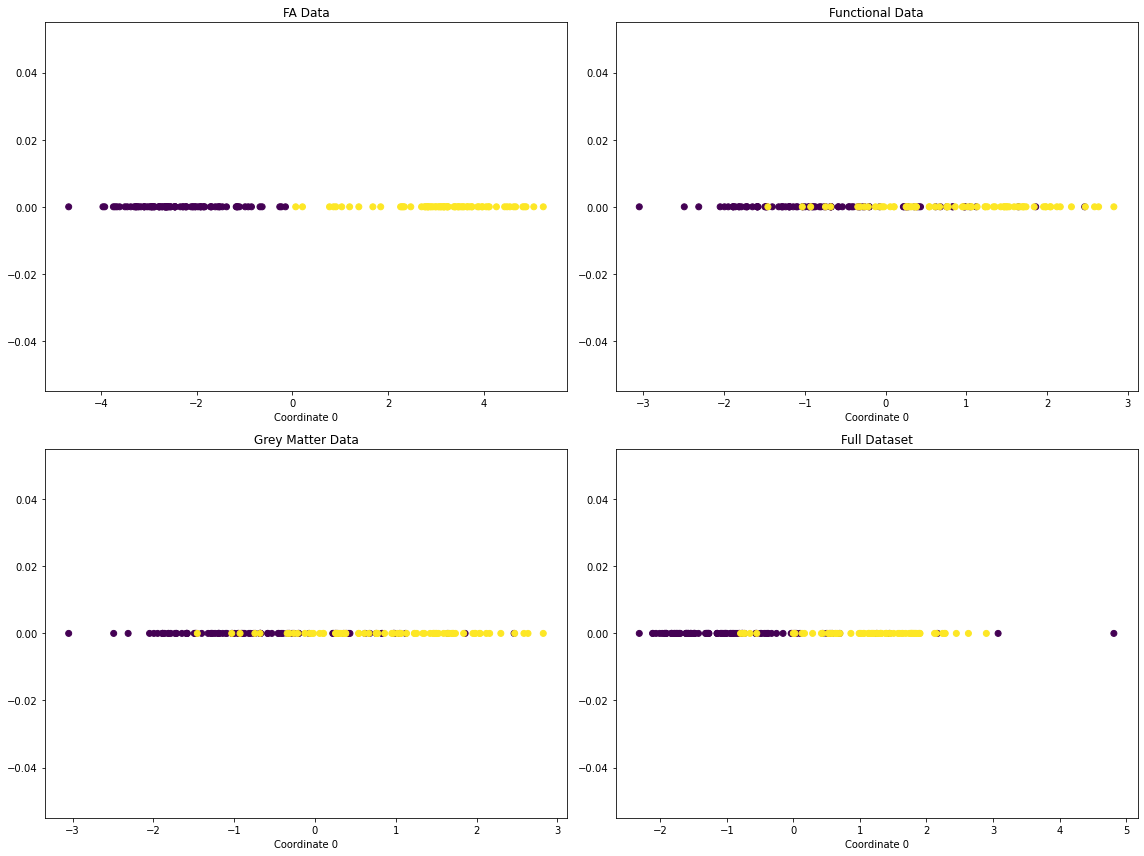

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i in range(2):
    for j in range(2):
        lda = LinearDiscriminantAnalysis()
        X_lda = lda.fit_transform(data[i+j], types["type"])
        
        # unsqueeze the variable
        X_lda = [num[0] for num in X_lda]
        X_lda_0 = [0 for num in range(len(X_lda))]

        axs[i, j].scatter(x=X_lda, y=X_lda_0, c=types["type"])

for i,ax in enumerate(axs.flat):
    ax.set(xlabel='Coordinate 0', title=names[i])
    
fig.tight_layout()

In [75]:
!pip install neuroCombat

You are using pip version 18.1, however version 21.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [80]:
# DATA = fa.iloc[:, :-5]
# BATCH_ID

neuroCombat.neuroCombat()

TypeError: neuroCombat() missing 3 required positional arguments: 'dat', 'covars', and 'batch_col'

In [160]:
# DATA MATRIX
test_data = fa.iloc[:, :-5].transpose()

# BATCH ID VECTOR
batch_id = [0 if t == 0 else 1 for t in types["type"]]

# Covars
covars = fa.iloc[:, :-5].transpose().corr()
covar_labels = np.array(covars.columns)

In [161]:
d = neuroCombat.neuroCombat(test_data, covars, covar_labels)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
c:\Users\franc\OneDrive\Documentos\Programació\Data Science\Projects\Capstone_Project\neuroCombat\neuroCombat\neuroCombat.py:253: RuntimeWarning: divide by zero encountered in true_divide
  s_data = ((X- stand_mean - mod_mean) / np.dot(np.sqrt(var_pooled), np.ones((1, n_sample))))
c:\Users\franc\OneDrive\Documentos\Programació\Data Science\Projects\Capstone_Project\neuroCombat\neuroCombat\neuroCombat.py:253: RuntimeWarning: invalid value encountered in true_divide
  s_data = ((X- stand_mean - mod_mean) / np.dot(np.sqrt(var_pooled), np.ones((1, n_sample))))
C:\Users\franc\AppData\Local\Programs\Python\Python38-32\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\franc\AppData\Local\Programs\Python\Python38-32\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: inval

In [171]:
fruit_0 = ["a", "b", "c", "d", "e"]
fruit_1 = ["a", "b", "c", "d", "e"]

np.where(fruit_0 == fruit_0)

(array([0], dtype=int32),)

In [185]:
list_0 = np.array([name for name in covars.columns])
list_1 = np.array([name for name in covars.columns])

batch_col = np.where(list_0 == list_1)[0][0]

In [189]:
cov = np.array(covars)
cov[:, batch_col]

array([1.        , 0.65661452, 0.73728726, 0.70365824, 0.72839067,
       0.69967326, 0.69671454, 0.70790359, 0.70397746, 0.70087825,
       0.71358266, 0.70387959, 0.69562264, 0.6882059 , 0.67094547,
       0.66947912, 0.69415135, 0.7157615 , 0.68795672, 0.71609995,
       0.61697909, 0.69287916, 0.75338126, 0.70197777, 0.66656179,
       0.69735711, 0.67898345, 0.68193106, 0.73171621, 0.68685424,
       0.71437507, 0.65828902, 0.67449961, 0.69791557, 0.68898153,
       0.69433906, 0.68492627, 0.69084613, 0.68612551, 0.69751848,
       0.70514724, 0.70743751, 0.6879816 , 0.70100874, 0.70921056,
       0.72008794, 0.73205034, 0.69564508, 0.7249857 , 0.64974317,
       0.68230452, 0.75192544, 0.65280587, 0.59270858, 0.68474496,
       0.73816664, 0.7270454 , 0.69286835, 0.6964426 , 0.60485882,
       0.70751227, 0.68698778, 0.71997673, 0.72023506, 0.7383957 ,
       0.69453266, 0.71621173, 0.68516916, 0.66482574, 0.67948706,
       0.75233943, 0.6865885 , 0.74312043, 0.66319911, 0.69982

In [204]:
batch = np.unique(cov[:, 0], return_inverse=True)
batch[-1]

array([157,  23, 149, 110, 144, 104,  93, 120, 112, 106, 126, 111,  87,
        68,  39,  33,  80, 128,  66, 129,   6,  78, 156, 109,  29,  97,
        48,  50, 146,  63, 127,  24,  43, 101,  71,  81,  59,  74,  61,
        98, 115, 118,  67, 107, 121, 132, 148,  88, 142,  15,  51, 154,
        17,   4,  56, 150, 143,  77,  91,   5, 119,  64, 131, 133, 151,
        83, 130,  60,  27,  49, 155,  62, 153,  25, 105, 152,  44,   0,
        52,  95,  41,  79, 136, 117,  40,  87,  99,  68,  39,  33,  80,
        30, 128,  66,  57,  96,  58,  20,  47,  19, 122,  18,  85,  22,
        35, 102,  69,  16, 140,  75,   1,  54,  12, 124,  32,  14, 103,
         2, 145,  70, 108, 147, 113,  84,  65,  76,  72,  45,   8,  94,
       134, 138, 123,  89, 137,  53,  42, 141, 139,  86,  90, 114, 135,
         3, 125,   7,  13,  21, 116,  73, 100,  11,  28,   9,  26,  10,
        31,  46,  37,  38,  34,  55,  92,  36,  82], dtype=int32)